## Analyses of proteins in human biomolecular condensates obtained from [CD-CODE](https://cd-code.org/)

This notebook reproduces Extended Data Fig. 6a–d

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.nonparametric import rank_compare_2indep
import random

def bootstrapped_cohens_d(a,b,n_bootstrap):
    cohens_d = (a.mean()-b.mean()) / np.sqrt(0.5*(a.std()**2+b.std()**2))
    cohens_d_bootstrap = np.empty(0)
    for _ in range(n_bootstrap):
        a_p = np.random.choice(a,size=a.size)
        b_p = np.random.choice(b,size=b.size)
        cohens_d_b = (a_p.mean()-b_p.mean()) / np.sqrt(0.5*(a_p.std()**2+b_p.std()**2))
        cohens_d_bootstrap = np.append(cohens_d_bootstrap,cohens_d_b)
    return cohens_d, np.std(cohens_d_bootstrap)

def calc_dof(x,y):
    nx = x.size
    ny = y.size
    rankc = stats.rankdata(np.concatenate((x,y)))
    rankcx = rankc[0:nx]
    rankcy = rankc[nx:nx+ny]
    rankcx_mean = np.mean(rankcx)
    rankcy_mean = np.mean(rankcy)
    rankx = stats.rankdata(x)
    ranky = stats.rankdata(y)
    rankx_mean = np.mean(rankx)
    ranky_mean = np.mean(ranky)

    Sx = np.sum(np.power(rankcx - rankx - rankcx_mean + rankx_mean, 2.0))
    Sx /= nx - 1
    Sy = np.sum(np.power(rankcy - ranky - rankcy_mean + ranky_mean, 2.0))
    Sy /= ny - 1

    df_numer = np.power(nx * Sx + ny * Sy, 2.0)
    df_denom = np.power(nx * Sx, 2.0) / (nx - 1)
    df_denom += np.power(ny * Sy, 2.0) / (ny - 1)
    return df_numer / df_denom

In [2]:
# Fetch list of human biomolecular condensates
api_url = "https://cd-code.org/api/condensates?species_tax_id=9606"
headers = {"Authorization": "b537fe97ad384aea9cbfd7b25b38938a"}
payload = {"page": 1, "size": 1000}
response = requests.get(api_url, headers=headers, params=payload)
dict_cd = json.loads(response.content.decode())

In [3]:
# Fetch drivers
drivers = np.empty(0)
no_func = 0

for cd_item in dict_cd['data']:
    api_url = f"https://cd-code.org/api/condensates/{cd_item['uid']:s}"
    headers = {"Authorization": "b537fe97ad384aea9cbfd7b25b38938a"}
    payload = {"page": 1, "size": 1000}
    response = requests.get(api_url, headers=headers, params=payload)
    dict_uid = json.loads(response.content.decode())['data']['protein_functional_type']
    if dict_uid == {}:
        no_func += 1
    drivers = np.append(drivers,[i.split('-')[0] for i in dict_uid if dict_uid[i]=="driver"])

In [4]:
# Fetch members
members = np.empty(0)

for cd_item in dict_cd['data']:
    api_url = f"https://cd-code.org/api/condensates/{cd_item['uid']:s}"
    headers = {"Authorization": "b537fe97ad384aea9cbfd7b25b38938a"}
    payload = {"page": 1, "size": 249}
    response = requests.get(api_url, headers=headers, params=payload)
    dict_uid = json.loads(response.content.decode())['data']['protein_functional_type']
    members = np.append(members,[i.split('-')[0] for i in dict_uid if dict_uid[i]=="member"])

In [5]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

In [6]:
nu_driver = df_idrome[df_idrome['UniProt_ID'].isin(drivers)].nu.values
nu_not_driver = df_idrome[~df_idrome['UniProt_ID'].isin(drivers)].nu.values

In [7]:
np.save('clinvar_fmug_cdcode/data/nu_driver.npy',nu_driver)
np.save('clinvar_fmug_cdcode/data/nu_not_driver.npy',nu_not_driver)

In [8]:
SPR_driver = df_idrome[df_idrome['UniProt_ID'].isin(drivers)].SPR.values
SPR_not_driver = df_idrome[~df_idrome['UniProt_ID'].isin(drivers)].SPR.values

In [9]:
np.save('clinvar_fmug_cdcode/data/SPR_driver.npy',SPR_driver)
np.save('clinvar_fmug_cdcode/data/SPR_not_driver.npy',SPR_not_driver)

In [10]:
nu_member = df_idrome[df_idrome['UniProt_ID'].isin(members)].nu.values
nu_not_member = df_idrome[~df_idrome['UniProt_ID'].isin(members)].nu.values

In [11]:
np.save('clinvar_fmug_cdcode/data/nu_member.npy',nu_member)
np.save('clinvar_fmug_cdcode/data/nu_not_member.npy',nu_not_member)

In [12]:
SPR_member = df_idrome[df_idrome['UniProt_ID'].isin(members)].SPR.values
SPR_not_member = df_idrome[~df_idrome['UniProt_ID'].isin(members)].SPR.values

In [13]:
np.save('clinvar_fmug_cdcode/data/SPR_member.npy',SPR_member)
np.save('clinvar_fmug_cdcode/data/SPR_not_member.npy',SPR_not_member)

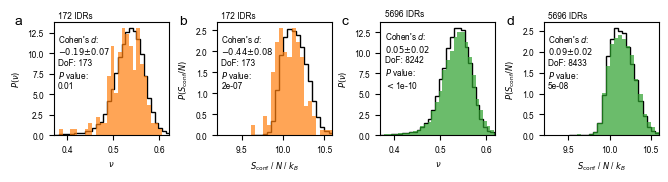

In [15]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(6.6,1.7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

for prop,prop_not,ax,bin_width,prop_max in zip([nu_driver,SPR_driver,nu_member,SPR_member],
                        [nu_not_driver,SPR_not_driver,nu_not_member,SPR_not_member],
                        [ax1,ax2,ax3,ax4],[.008,.05,.008,.05],[.65,11,.65,11]):
    
    bins = np.arange(prop.min(), prop_max, bin_width)
    x = bins[:-1]+bin_width/2.
    
    ax.hist(prop_not,bins,density=True,histtype='step',color='k',zorder=0)

    statistic, p_twosided = stats.brunnermunzel(prop, prop_not, alternative='two-sided')
    statistic, p_less = stats.brunnermunzel(prop, prop_not, alternative='less')
    statistic, p_greater = stats.brunnermunzel(prop, prop_not, alternative='greater')

    p_value = p_greater
    color = 'tab:green'
    if p_less < p_greater:
        color = 'tab:orange'
        p_value = p_less
        
    cohensd, cohensd_se = bootstrapped_cohens_d(prop, prop_not, 100000)
    cohensd_label = f"Cohen's $d$:\n${cohensd:.2f}±{cohensd_se:.2f}$"        
    p_value_label = f'$P$ value:\n{p_value:.1g}' if p_value >= 1e-10 else '$P$ value:\n$<$1e-10'
    dof = f'\nDoF: {calc_dof(prop, prop_not):.0f}'

    h = np.histogram(prop,bins=bins,density=True)[0]

    ax.bar(x,h,alpha=.7,width=bin_width,color=color,
           label=f'{prop.size:d} IDRs\n\n'+cohensd_label+dof+'\n'+p_value_label)

    ax.legend(handlelength=0,frameon=False,borderpad=0,loc=(-.02,.4))
    
ax1.set_ylabel('$P(\\nu)$')
ax1.set_xlabel('$\\nu$')
ax3.set_ylabel('$P(\\nu)$')
ax3.set_xlabel('$\\nu$')
ax2.set_ylabel('$P(S_\mathrm{conf}/N)$')
ax2.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax4.set_ylabel('$P(S_\mathrm{conf}/N)$')
ax4.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax1.set_xlim(.37,.62)
ax3.set_xlim(.37,.62)
ax2.set_xlim(9.2,10.6)
ax4.set_xlim(9.2,10.6)

f.text(0.01, .92, 'a', fontsize=10)
f.text(0.26, .92, 'b', fontsize=10)
f.text(0.505, .92, 'c', fontsize=10)
f.text(0.755, .92, 'd', fontsize=10)

plt.tight_layout()
plt.savefig('figs/ED_fig6a.pdf')